<a href="https://colab.research.google.com/github/nilabja10201992/Cryptocurrency-Price-Prediction/blob/master/compare_LSTM_GRU_CONV1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9,la;q=0.8,hi;q=0.7,fr;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/1346/330249/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556692071&Signature=JKsfB4DXsi178h5Th5nVO9XclVPnr2skZpy97UY6CC0gCRvpcR%2Fg13rO5AaX3ReMqd1rum%2BwidFXorsHBCmkUxxrGwZBKPUq1egenh%2BYzT5lPExCwty8ludzxMAmzXKmMaNRwaq0eIxKyeZlzjYAGfvLLDcXGd7QZSJ6eofWXhS6iCK%2FfzkkCUTEBj0zspZ6xVvHQLYaDdfcwXeB1dC2%2BVfZQ3siRdqX%2FRFWZfiG4tBKxq4K2rlJT5FQEQTctaAKJVUYlXD679GWtzSf5ElcfZckN0xhmAuBawp8IGRB36mH%2Fo1VjWSDrBy0rSEmSSTGCCN6TDLFnS0OrWHJG%2Bc4Qg%3D%3D" -O "bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip" -c

--2019-04-29 04:18:36--  https://storage.googleapis.com/kaggle-datasets/1346/330249/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556692071&Signature=JKsfB4DXsi178h5Th5nVO9XclVPnr2skZpy97UY6CC0gCRvpcR%2Fg13rO5AaX3ReMqd1rum%2BwidFXorsHBCmkUxxrGwZBKPUq1egenh%2BYzT5lPExCwty8ludzxMAmzXKmMaNRwaq0eIxKyeZlzjYAGfvLLDcXGd7QZSJ6eofWXhS6iCK%2FfzkkCUTEBj0zspZ6xVvHQLYaDdfcwXeB1dC2%2BVfZQ3siRdqX%2FRFWZfiG4tBKxq4K2rlJT5FQEQTctaAKJVUYlXD679GWtzSf5ElcfZckN0xhmAuBawp8IGRB36mH%2Fo1VjWSDrBy0rSEmSSTGCCN6TDLFnS0OrWHJG%2Bc4Qg%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71025792 (68M) [application/zip]
Saving to: ‘bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip’

bitstampUSD_1-min_d 100%[===================>]  

In [2]:
!unzip bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip

Archive:  bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv  


In [3]:
!ls

bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv	 sample_data
bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Dropout, CuDNNGRU, Bidirectional, Convolution1D, MaxPooling1D, Flatten, Activation
from keras.optimizers import SGD
import math
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error


Using TensorFlow backend.


In [0]:
def mean_absolute_scaled_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    dem = 0
    num = 0
    for i in range(n-1):
        dem += abs(y_true[i+1] - y_true[i])
    for i in range(n):
        num = abs(y_pred[i] - y_true[i])
        num = np.squeeze(num)
        res += num/dem
    res = np.squeeze(res)
    #print(num, dem, res)
    return res/n

In [0]:
def systematic_mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    for i in range(n):
        num = np.abs(y_pred[i] - y_true[i])
        dem = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
        res += num/dem
    res = np.squeeze(res)
    return 100*(res/n)

In [8]:
train_df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
train_df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.778817e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06
mean,1.438908e+09,2.654668e+03,2.656783e+03,2.652286e+03,2.654650e+03,1.068140e+01,2.395856e+04,2.654510e+03
std,6.561491e+07,3.529553e+03,3.533184e+03,3.525347e+03,3.529522e+03,3.476243e+01,8.829950e+04,3.529271e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.382000e+09,3.489800e+02,3.491500e+02,3.487800e+02,3.489900e+02,4.500000e-01,2.480382e+02,3.489681e+02
50%,1.439071e+09,6.595600e+02,6.600000e+02,6.589900e+02,6.596200e+02,2.095163e+00,1.814312e+03,6.595521e+02
75%,1.495753e+09,4.045492e+03,4.049115e+03,4.042050e+03,4.045400e+03,8.284949e+00,1.303504e+04,4.045115e+03
max,1.552435e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


In [9]:
a = train_df[1200000:].fillna(method="backfill")
a.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1200000,1397317920,423.70,423.70,423.68,423.68,4.000000,1694.754000,423.688500
1200001,1397317980,423.67,423.67,423.67,423.67,0.950200,402.571234,423.670000
1200002,1397318040,423.60,423.60,423.55,423.55,1.517910,642.931121,423.563400
1200003,1397318100,423.55,423.55,423.55,423.55,1.000000,423.550000,423.550000
1200004,1397318160,423.48,423.49,423.48,423.49,1.039435,440.186555,423.486431


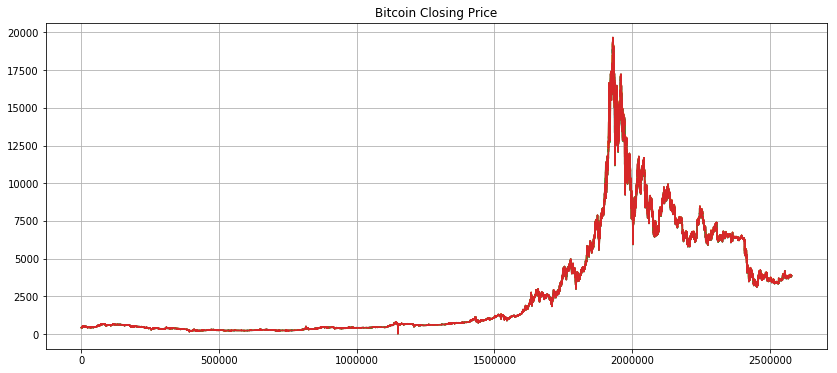

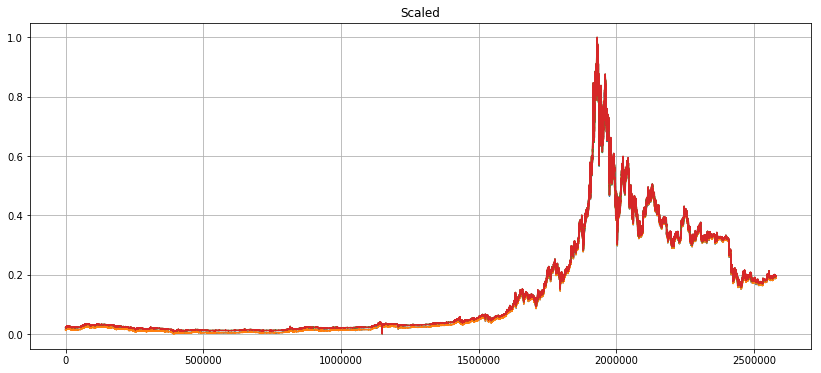

In [10]:
weighted_price = np.array(a.iloc[:,[1,2,3,4]])
plt.figure(figsize=(14,6))
plt.title("Bitcoin Closing Price")
plt.grid()
plt.plot(weighted_price)
sclow = MinMaxScaler()
low_price = np.array(a.iloc[:,[3]])
low_priceSC = sclow.fit_transform(low_price)
sc = MinMaxScaler()
weighted_priceSC = sc.fit_transform(weighted_price)
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
plt.plot(weighted_priceSC)

In [11]:
timestep = 60
X = []
y = []
for i in range(timestep, len(weighted_priceSC)):
    X.append(weighted_priceSC[i-timestep:i, :])
    y.append(low_priceSC[i])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(2578757, 60, 4) (2578757, 1)


In [12]:
print(X.shape, y.shape)

(2578757, 60, 4) (2578757, 1)


In [0]:
X_train = X[:2400000,:]
X_test = X[2400000:,:]

y_train = y[:2400000]
y_test = y[2400000:]

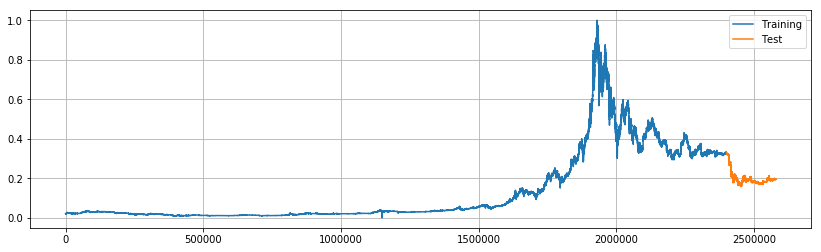

In [14]:
plt.figure(figsize=(14,4))
plt.plot(range(2400000),y_train)
plt.plot(range(2400000, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()


In [0]:
X_train = X_train.reshape(-1,timestep,4)
X_test = X_test.reshape(-1,timestep,4)

In [16]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(CuDNNLSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(CuDNNLSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(CuDNNLSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(CuDNNLSTM(units=256))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=5, batch_size=2048)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2400000/2400000 [==============================] - 214s 89us/step - loss: 0.0090
Epoch 2/5
2400000/2400000 [==============================] - 224s 93us/step - loss: 0.0069
Epoch 3/5
2400000/2400000 [==============================] - 226s 94us/step - loss: 0.0067
Epoch 4/5
2400000/2400000 [==============================] - 228s 95us/step - loss: 0.0066
Epoch 5/5
2400000/2400000 [==============================] - 227s 95us/step - loss: 0.0065
CPU times: user 10min 2s, sys: 4min 22s, total: 14min 25s
Wall time: 18min 43s


In [17]:
%%time
y_pred = regressor.predict(X_test)

CPU times: user 36.7 s, sys: 1.09 s, total: 37.7 s
Wall time: 32.8 s


In [18]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

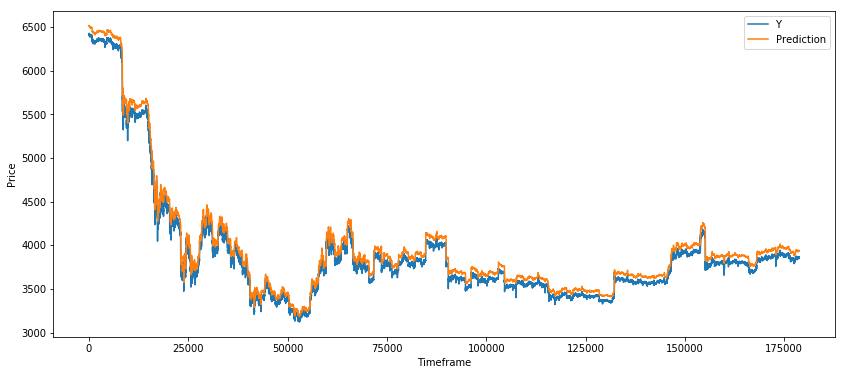

In [19]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


In [20]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}\nMean square error {3}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

Mean absolute error 0.003920612201132355
Systematic mean absolute percentage error 1.9485733050782654 
Mean_absolute_scaled_error 0.00019121183525146757
Mean square error 1.6476124907311402e-05


In [21]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(CuDNNGRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(CuDNNGRU(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(CuDNNGRU(units=128, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(CuDNNGRU(units=256))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=10, batch_size=2048)

Epoch 1/10
2400000/2400000 [==============================] - 190s 79us/step - loss: 0.0090
Epoch 2/10
2400000/2400000 [==============================] - 191s 80us/step - loss: 0.0068
Epoch 3/10
2400000/2400000 [==============================] - 191s 80us/step - loss: 0.0065
Epoch 4/10
2400000/2400000 [==============================] - 191s 79us/step - loss: 0.0064
Epoch 5/10
2400000/2400000 [==============================] - 191s 80us/step - loss: 0.0063
Epoch 6/10
2400000/2400000 [==============================] - 192s 80us/step - loss: 0.0064
Epoch 7/10
2400000/2400000 [==============================] - 192s 80us/step - loss: 0.0063
Epoch 8/10
2400000/2400000 [==============================] - 191s 80us/step - loss: 0.0063
Epoch 9/10
2400000/2400000 [==============================] - 191s 80us/step - loss: 0.0063
Epoch 10/10
2400000/2400000 [==============================] - 191s 79us/step - loss: 0.0062
CPU times: user 17min 26s, sys: 7min 29s, total: 24min 55s
Wall time: 31min 52s

In [22]:
%%time
y_pred = regressor.predict(X_test)

CPU times: user 34.9 s, sys: 938 ms, total: 35.8 s
Wall time: 32.9 s


In [23]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

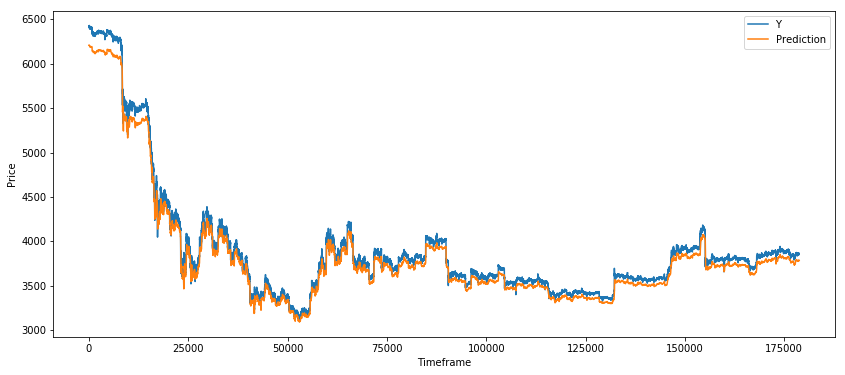

In [24]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


In [25]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}\nMean square error {3}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

Mean absolute error 0.004002819348504943
Systematic mean absolute percentage error 1.9584213820802665 
Mean_absolute_scaled_error 0.00019522115285634448
Mean square error 1.9673177259541334e-05


In [26]:
%%time
# The LSTM architecture
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (X_train.shape[1],4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(CuDNNLSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))
# Compiling the RNN
model.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = model.fit(X_train, y_train, epochs=10, batch_size=2048)

Epoch 1/10
2400000/2400000 [==============================] - 37s 15us/step - loss: 0.0043
Epoch 2/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0023
Epoch 3/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0018
Epoch 4/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0018
Epoch 5/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0017
Epoch 6/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0016
Epoch 7/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0016
Epoch 8/10
2400000/2400000 [==============================] - 36s 15us/step - loss: 0.0015
Epoch 9/10
2400000/2400000 [==============================] - 35s 15us/step - loss: 0.0014
Epoch 10/10
2400000/2400000 [==============================] - 36s 15us/step - loss: 0.0015
CPU times: user 3min 49s, sys: 1min 8s, total: 4min 58s
Wall time: 5min 56s


In [27]:
%%time
y_pred = model.predict(X_test)

CPU times: user 13.7 s, sys: 927 ms, total: 14.7 s
Wall time: 10.8 s


In [28]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

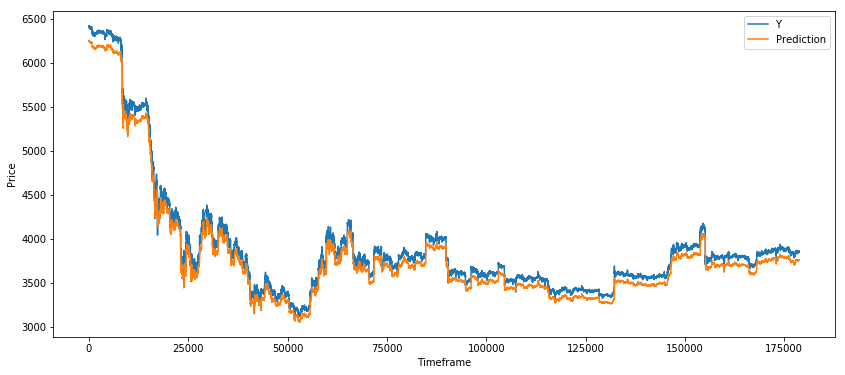

In [29]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [30]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}\nMean square error {3}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

Mean absolute error 0.004977047362997034
Systematic mean absolute percentage error 2.5250121203522746 
Mean_absolute_scaled_error 0.00024273514226611677
Mean square error 2.6181189837540414e-05
